In [1]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

%matplotlib inline

In [2]:
data_dir = "games_collected"

In [6]:
actual = os.listdir(f"{data_dir}/composite")
actual = [a.replace(".png", "") for a in actual]
composites = {}
for a in actual:
    composites[a] = True

df = pd.read_csv(f'{data_dir}/full_coordinates.csv')
df = df.sort_values(by=['image_name'])
df = df[df['image_name'].isin(actual)]

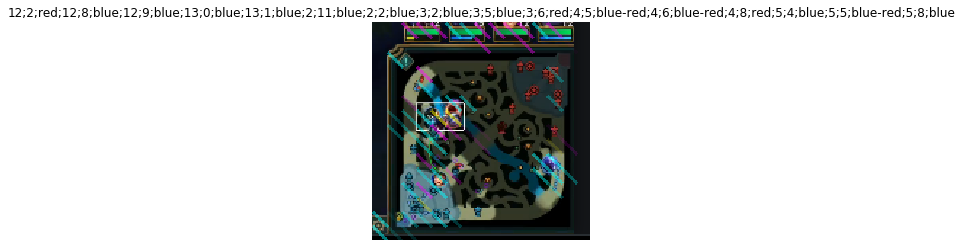

In [7]:
data = (ImageList.from_df(df, data_dir+"/composite", suffix='.png')
        .split_by_idx(range(0,int(len(df)/5)))
        .label_from_df(label_delim=' ')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data.show_batch(rows=1)

https://gilberttanner.com/blog/fastai-multi-label-image-classification

In [8]:
thresh = 0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
f_score = partial(fbeta, thresh=thresh)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
gc.collect()

2339

In [9]:
# learn.lr_find()
# learn.recorder.plot()

In [10]:
lr = 0.02
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.074267,0.078221,0.969232,0.265592,04:38


Better model found at epoch 0 with valid_loss value: 0.07822111248970032.


In [11]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(6, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.067252,0.072017,0.968310,0.386755,06:05
1,0.066660,0.072069,0.968592,0.385727,06:07
2,0.063597,0.071263,0.968782,0.405077,06:04
3,0.059873,0.070210,0.967991,0.428204,06:05
4,0.057210,0.070295,0.968384,0.432277,06:07
5,0.055107,0.070895,0.968714,0.429178,06:09


Better model found at epoch 0 with valid_loss value: 0.07201723009347916.
Better model found at epoch 2 with valid_loss value: 0.07126272469758987.
Better model found at epoch 3 with valid_loss value: 0.07021000981330872.


### Results
* learn.fit_one_cycle(10, slice(1e-5, lr/5)) == lr=0.05 Resnet50 == No Composite
* Better model found at epoch 7 with valid_loss value: 0.16599667072296143.
* learn.fit_one_cycle(10, slice(1e-5, lr/5)) == lr=0.05 Resnet50 == Stripe composite
* Better model found at epoch 4 with valid_loss value: 0.16605345904827118.

In [50]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [57]:
grid_size = 10
def draw_grid(draw, labels):
    for l in labels:
        fill = (0, 0, 255, 96)
        if l[2] == "red":
            fill = (255, 0, 0, 96)
        if l[2] == "blue-red":
            fill = (255, 255, 0, 96)
        x = l[0] * grid_size
        y = l[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def process(image):
    plt.figure()
    plt.imshow(image)
        
def draw_preds(index):
    p = preds[0][index]
    classes = [data.classes[i] for i in range(len(p)) if p[i] > thresh]
    classes = [(int(c.split(";")[0]), int(c.split(";")[1]), c.split(";")[2]) for c in classes]
    print(classes)


    filename = learn.data.valid_ds.items[index]
    full_name = filename.split("/")[-1]
    full_name = data_dir+"/full/"+full_name
    img = PIL.Image.open(full_name).convert("RGBA")

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, classes)
    out = PIL.Image.alpha_composite(img, overlay)

    process(out)
    img = PIL.Image.open(filename)
    process(img)

In [58]:
k = 1200

[(11, 11, 'blue'), (12, 10, 'blue-red'), (12, 10, 'red'), (12, 11, 'blue'), (12, 11, 'blue-red'), (13, 10, 'red'), (3, 2, 'red'), (3, 6, 'blue'), (4, 2, 'red'), (4, 7, 'blue'), (6, 7, 'blue'), (7, 6, 'red'), (7, 7, 'blue-red'), (7, 7, 'red'), (8, 6, 'red'), (8, 7, 'red')]


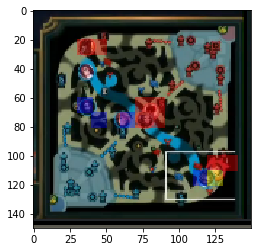

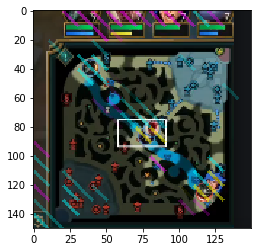

In [183]:
thresh = 0.2
k = random.randint(10, 8000)
draw_preds(k)

In [154]:
learn.export("models/predict.pth")